# Delta-Delta

> Explanation of how to calculate delta-delta using DABEST.

- order: 5

Since version 2023.02.14, DABEST also supports the calculation of delta-delta, an experimental function that facilitates the comparison between two bootstrapped effect sizes computed from two independent categorical variables. 

Many experimental designs investigate the effects of two interacting independent variables on a dependent variable. The delta-delta effect size enables us distill the net effect of the two variables. To illustrate this, let's explore the following  problem. 

Consider an experiment where we test the efficacy of a drug named ``Drug`` on a disease-causing mutation ``M`` based on disease metric ``Y``. The greater the value ``Y`` has, the more severe the disease phenotype is. Phenotype ``Y`` has been shown to be caused by a gain-of-function mutation ``M``, so we expect a difference between wild type (``W``) subjects and mutant subjects (``M``). Now, we want to know whether this effect is ameliorated by the administration of ``Drug`` treatment. We also administer a placebo as a control. In theory, we only expect ``Drug`` to have an effect on the ``M`` group, although in practice, many drugs have non-specific effects on healthy populations too.

Effectively, we have four groups of subjects for comparison.

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug  | X<sub>D, W</sub> | X<sub>D, M</sub> |
| Placebo | X<sub>P, W</sub> | X<sub>P, M</sub> |

There are two ``Treatment`` conditions, ``Placebo`` (control group) and ``Drug`` (test group). There are two ``Genotype``\s: ``W`` (wild type population) and ``M`` (mutant population). Additionally, each experiment was conducted twice (``Rep1`` and ``Rep2``). We will perform several analyses to visualise these differences in a simulated dataset. 


## Load libraries

In [ ]:
import numpy as np
import pandas as pd
import dabest

print("We're using DABEST v{}".format(dabest.__version__))

We're using DABEST v2024.03.29


In [ ]:
#| hide
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # to suppress warnings related to points not being able to be plotted due to dot size

## Simulate a dataset

In [ ]:
from scipy.stats import norm # Used in generation of populations.
np.random.seed(9999) # Fix the seed to ensure reproducibility of results.

# Create samples
N = 20
y = norm.rvs(loc=3, scale=0.4, size=N*4)
y[N:2*N] = y[N:2*N]+1
y[2*N:3*N] = y[2*N:3*N]-0.5

# Add a `Treatment` column
t1 = np.repeat('Placebo', N*2).tolist()
t2 = np.repeat('Drug', N*2).tolist()
treatment = t1 + t2 

# Add a `Rep` column as the first variable for the 2 replicates of experiments done
rep = []
for i in range(N*2):
    rep.append('Rep1')
    rep.append('Rep2')

# Add a `Genotype` column as the second variable
wt = np.repeat('W', N).tolist()
mt = np.repeat('M', N).tolist()
wt2 = np.repeat('W', N).tolist()
mt2 = np.repeat('M', N).tolist()


genotype = wt + mt + wt2 + mt2

# Add an `id` column for paired data plotting.
id = list(range(0, N*2))
id_col = id + id 


# Combine all columns into a DataFrame.
df_delta2 = pd.DataFrame({'ID'        : id_col,
                  'Rep'      : rep,
                   'Genotype'  : genotype, 
                   'Treatment': treatment,
                   'Y'         : y
                })

In [ ]:
df_delta2.head()

,ID,Rep,Genotype,Treatment,Y
0,0,Rep1,W,Placebo,2.793984
1,1,Rep2,W,Placebo,3.236759
2,2,Rep1,W,Placebo,3.019149
3,3,Rep2,W,Placebo,2.804638
4,4,Rep1,W,Placebo,2.858019


## Unpaired data

To create a delta-delta plot, you simply need to set ``delta2=True`` in the 
``dabest.load()`` function. However, in this case,``x`` needs to be declared as a list consisting of 2 elements, unlike most cases where it is a single element. The first element in ``x`` will represent the variable plotted along the horizontal axis, and the second one will determine the color of dots for scattered plots or the color of lines for slope graphs. We use the ``experiment`` input to specify the grouping of the data.

In [ ]:
unpaired_delta2 = dabest.load(data = df_delta2, x = ["Genotype", "Genotype"], y = "Y", delta2 = True, experiment = "Treatment")

/Users/jonathananns/GitHub/DABEST-python/dabest/_dabest_object.py:125: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  all_plot_groups = pd.unique([tt for t in idx for tt in t]).tolist()


The above function creates the following object: 

In [ ]:
unpaired_delta2

DABEST v2024.03.29
                  
Good afternoon!
The current time is Thu Nov 28 14:54:27 2024.

Effect size(s) with 95% confidence intervals will be computed for:
1. M Placebo minus W Placebo
2. M Drug minus W Drug
3. Drug minus Placebo (only for mean difference)

5000 resamples will be used to generate the effect size bootstraps.


We can quickly check out the effect sizes:

In [ ]:
unpaired_delta2.mean_diff

DABEST v2024.03.29
                  
Good afternoon!
The current time is Thu Nov 28 14:54:28 2024.

The unpaired mean difference between W Placebo and M Placebo is 1.23 [95%CI 0.948, 1.52].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

The unpaired mean difference between W Drug and M Drug is 0.326 [95%CI 0.0934, 0.584].
The p-value of the two-sided permutation t-test is 0.0122, calculated for legacy purposes only. 

The delta-delta between Placebo and Drug is -0.903 [95%CI -1.27, -0.522].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical 

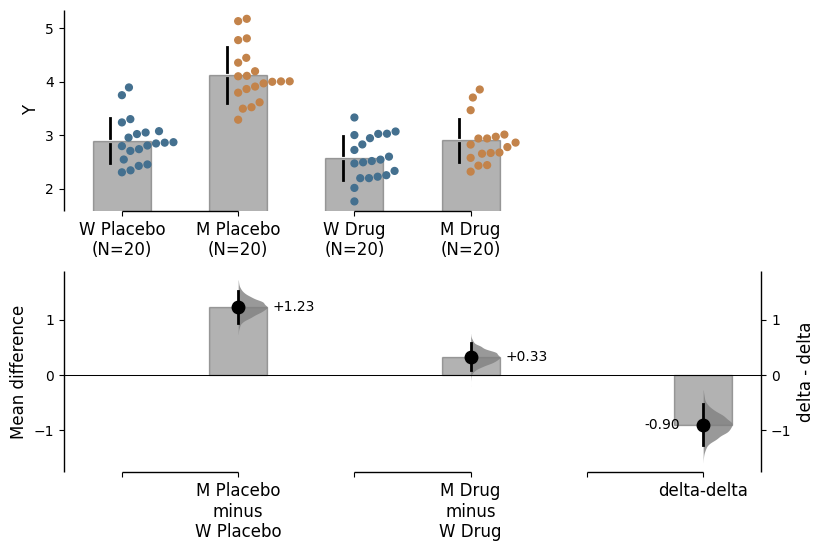

In [ ]:
unpaired_delta2.mean_diff.plot();

In the above plot, the horizontal axis represents the ``Genotype`` condition
and the dot colour is also specified by ``Genotype``. The left pair of 
scattered plots is based on the ``Placebo`` group while the right pair is based
on the ``Drug`` group. The bottom left axis contains the two primary deltas: the ``Placebo`` delta 
and the ``Drug`` delta. We can easily see that when only the placebo was 
administered, the mutant phenotype is around 1.23 [95%CI 0.948, 1.52]. This difference was shrunken to around 0.326 [95%CI 0.0934, 0.584] when the drug was administered. This gives us some indication that the drug is effective in amiliorating the disease phenotype. Since the ``Drug`` did not completely eliminate the mutant phenotype, we have to calculate how much net effect the drug had. This is where ``delta-delta`` comes in. We use the ``Placebo`` delta as a reference for how much the mutant phenotype is supposed to be, and we subtract the ``Drug`` delta from it. The bootstrapped mean differences (delta-delta) between the ``Placebo`` 
and ``Drug`` group are plotted at the right bottom with a separate y-axis from other bootstrap plots. 
This effect size, at about -0.903 [95%CI -1.28, -0.513], is the net effect size of the drug treatment. That is to say that treatment with drug A reduced disease phenotype by 0.903.

The mean difference between mutants and wild types given the placebo treatment is:

$\Delta_{1} = \overline{X}_{P, M} - \overline{X}_{P, W}$

The mean difference between mutants and wild types given the drug treatment is:


$\Delta_{2} = \overline{X}_{D, M} - \overline{X}_{D, W}$

The net effect of the drug on mutants is:
    


$\Delta_{\Delta} = \Delta_{2} - \Delta_{1}$
    

where $\overline{X}$ is the sample mean, $\Delta$ is the mean difference.

## Specifying grouping for comparisons

In the example above, we used the convention of *test - control* but you can manipulate the orders of the experiment groups as well as the horizontal axis variable by setting the paremeters ``experiment_label`` and ``x1_level``.


/Users/jonathananns/GitHub/DABEST-python/dabest/_dabest_object.py:125: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  all_plot_groups = pd.unique([tt for t in idx for tt in t]).tolist()


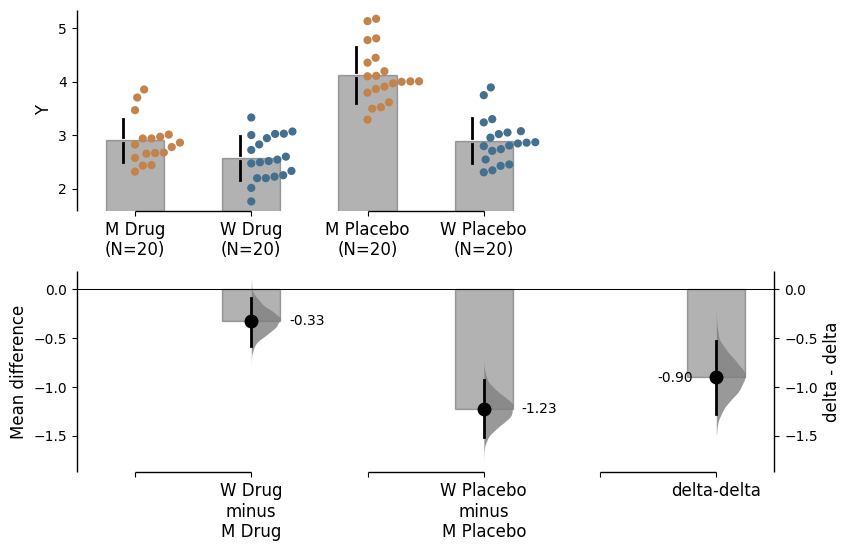

In [ ]:
unpaired_delta2_specified = dabest.load(data = df_delta2, 
                                            x = ["Genotype", "Genotype"], y = "Y", 
                                            delta2 = True, experiment = "Treatment",
                                            experiment_label = ["Drug", "Placebo"],
                                            x1_level = ["M", "W"])

unpaired_delta2_specified.mean_diff.plot();

## Paired data

The delta-delta function also supports paired data, providing a useful alternative visualization of the data. Assuming that the placebo and drug treatment were administered to the same subjects, our data is paired between the treatment conditions. We can specify this by using ``Treatment`` as ``x`` and ``Genotype`` as ``experiment``, and we further specify that ``id_col`` is ``ID``, linking data from the same subject with each other. Since we have conducted two replicates of the experiments, we can also colour the slope lines according to ``Rep``. 

/Users/jonathananns/GitHub/DABEST-python/dabest/_dabest_object.py:125: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  all_plot_groups = pd.unique([tt for t in idx for tt in t]).tolist()


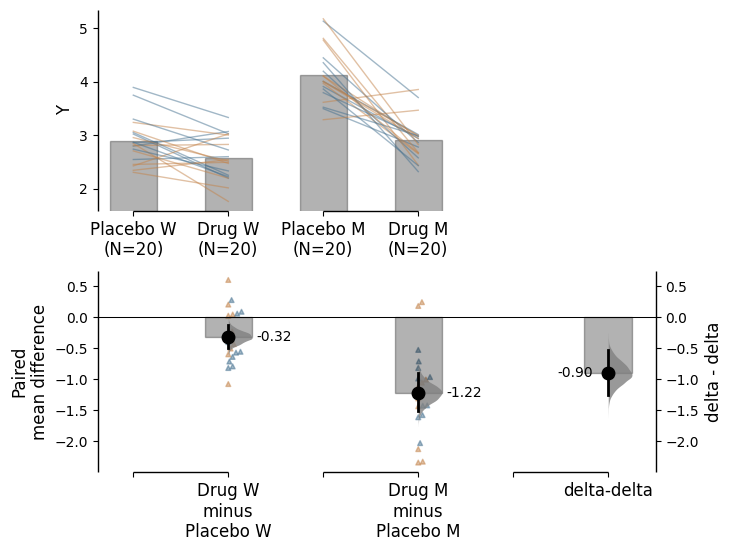

In [ ]:
paired_delta2 = dabest.load(data = df_delta2, 
                                paired = "baseline", id_col="ID",
                                x = ["Treatment", "Rep"], y = "Y", 
                                delta2 = True, experiment = "Genotype")
paired_delta2.mean_diff.plot();

We see that the drug had a non-specific effect of -0.321 [95%CI -0.498, -0.131] on wild type subjects even when they were not sick, and it had a bigger effect of -1.22 [95%CI -1.52, -0.906] in mutant subjects. In this visualisation, we can see the delta-delta value of -0.903 [95%CI -1.21, -0.587] as the net effect of the drug accounting for non-specific actions in healthy individuals. 


The mean difference between drug and placebo treatments in wild type subjects is:

$$\Delta_{1} = \overline{X}_{D, W} - \overline{X}_{P, W}$$

The mean difference between drug and placebo treatments in mutant subjects is:

$$\Delta_{2} = \overline{X}_{D, M} - \overline{X}_{P, M}$$

The net effect of the drug on mutants is:

$$\Delta_{\Delta} = \Delta_{2} - \Delta_{1}$$

where $\overline{X}$ is the sample mean, $\Delta$ is the mean difference.

## Standardising delta-delta effect sizes with Deltas' g

Standardized mean difference statistics like Cohen's d and Hedges' g quantify effect sizes in terms of the sample variance. We have introduced a metric, *Deltas' g*, to standardize delta-delta effects. This metric enables the comparison between measurements of different dimensions.

The standard deviation of the delta-delta value is calculated from a pooled variance of the 4 samples:

$$s_{\Delta_{\Delta}} = \sqrt{\frac{(n_{D, W}-1)s_{D, W}^2+(n_{P, W}-1)s_{P, W}^2+(n_{D, M}-1)s_{D, M}^2+(n_{P, M}-1)s_{P, M}^2}{(n_{D, W} - 1) + (n_{P, W} - 1) + (n_{D, M} - 1) + (n_{P, M} - 1)}}$$

where $s$ is the standard deviation and $n$ is the sample size.

A deltas' g value is then calculated as delta-delta value divided by pooled standard deviation $s_{\Delta_{\Delta}}$:


$\Delta_{g} = \frac{\Delta_{\Delta}}{s_{\Delta_{\Delta}}}$

In [ ]:
unpaired_delta2.delta_g

DABEST v2024.03.29
                  
Good afternoon!
The current time is Thu Nov 28 14:54:32 2024.

The unpaired deltas' g between W Placebo and M Placebo is 2.54 [95%CI 1.68, 3.28].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

The unpaired deltas' g between W Drug and M Drug is 0.793 [95%CI 0.152, 1.34].
The p-value of the two-sided permutation t-test is 0.0122, calculated for legacy purposes only. 

The deltas' g between Placebo and Drug is -2.11 [95%CI -2.97, -1.22].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.delta_

We see the standardised delta-delta value of -2.11 standard deviations [95%CI -2.98, -1.2] as the net effect of the drug accounting for non-specific actions in healthy individuals. 

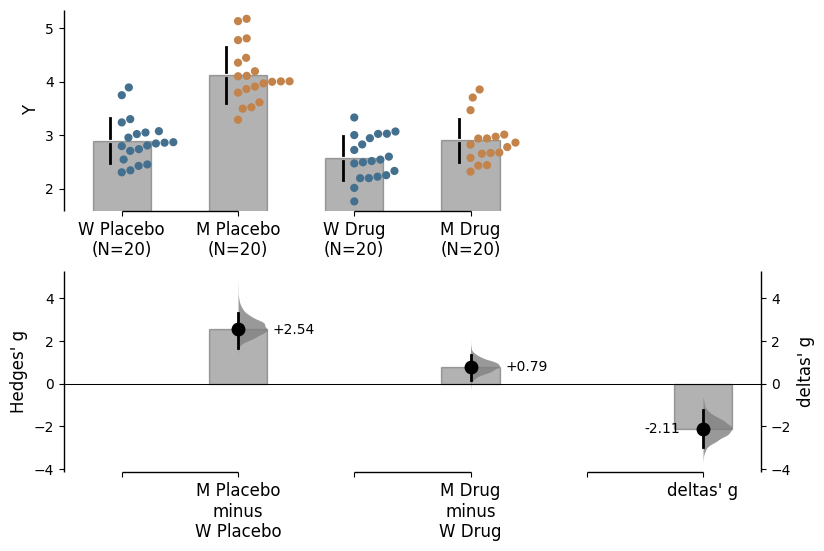

In [ ]:
unpaired_delta2.delta_g.plot();

## Connection to ANOVA

The configuration of comparison we performed above is reminiscent of a two-way ANOVA. In fact, the delta - delta is an effect size estimated for the interaction term between ``Treatment`` and ``Genotype``. Main effects of ``Treatment`` and ``Genotype``, on the other hand, can be determined by simpler, univariate contrast plots. 

## Omitting delta-delta plot

If for some reason you don't want to display the delta-delta plot, you can easily do so by 


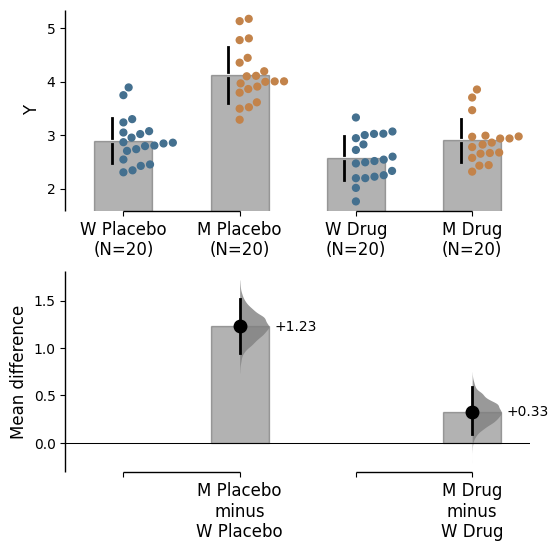

In [ ]:
unpaired_delta2.mean_diff.plot(show_delta2=False);

## Other effect sizes


Since the delta-delta function is only applicable to mean differences, plots 
of other effect sizes will not include a delta-delta bootstrap plot.

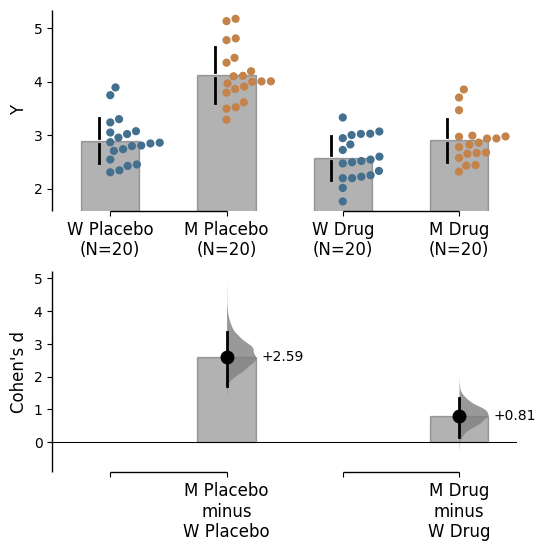

In [ ]:
unpaired_delta2.cohens_d.plot();

## Statistics

You can find all outputs of the delta-delta calculation by assessing the attribute named ``delta_delta`` of the effect size object.

### Delta-delta statistics

In [ ]:
unpaired_delta2.mean_diff.delta_delta

DABEST v2024.03.29
                  
Good afternoon!
The current time is Thu Nov 28 14:54:34 2024.

The delta-delta between Placebo and Drug is -0.903 [95%CI -1.27, -0.522].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

### Standardised delta-delta statistics 

In [ ]:
unpaired_delta2.delta_g.delta_delta

DABEST v2024.03.29
                  
Good afternoon!
The current time is Thu Nov 28 14:54:34 2024.

The deltas' g between Placebo and Drug is -2.11 [95%CI -2.97, -1.22].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

The ``delta_delta`` object has its own attributes, containing various information of delta - delta.

  - ``difference``: the mean bootstrapped differences between the 2 groups of bootstrapped mean differences 
  - ``bootstraps``: the 2 groups of bootstrapped mean differences 
  - ``bootstraps_delta_delta``: the bootstrapped differences between the 2 groups of bootstrapped mean differences 
  - ``permutations``: the mean difference between the two groups of bootstrapped mean differences calculated based on the permutation data
  - ``permutations_var``: the pooled group variances of two groups of bootstrapped mean differences calculated based on permutation data
  - ``permutations_delta_delta``: the delta-delta calculated based on the permutation data

``delta_delta.to_dict()`` will return all the attributes in a dictionary format.